In [392]:
import os
import ast
import subprocess
import collections
import re
import csv
import httplib
import nltk
import psycopg2
import sqlite3 as sq
import scipy
import requests
import urllib
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
import matplotlib.pyplot as plt
from lxml import html
from imdbpie import Imdb
from collections import Counter
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer


%matplotlib inline

In [394]:
# Deprecated. Used to reset tables when going through initial runs of the code below.

#ct.execute('''DROP TABLE top''')
#cb.execute('''DROP TABLE bot''')

In [393]:
# Connect to local DB

conntop = sq.connect('imdb_top')
ct = conntop.cursor()

connbot = sq.connect('imdb_bot')
cb = conntop.cursor()

In [395]:
# Create table and commit query.
ct.execute('''CREATE TABLE top (can_rate text, num_votes real, rating real, tconst text, title text, type text, year real, image text)''')

conntop.commit()

In [396]:
# Create table and commit query.
cb.execute('''CREATE TABLE bot (can_rate text, num_votes real, rating real, tconst text, title text, type text, year real, image text)''')
connbot.commit()

I got the movie id from here: http://www.imdb.com/title/tt0468569/

In [456]:
# Created class modification of existing IMDBpie class that queried bottom 100 list of movies.

class Imdb_sup(Imdb):
    def bottom(self):
        url = self._build_url('/chart/bottom', {})
        response = self._get(url)
        return response['data']['list']['list']

In [459]:
# Instantiate and grab the top 250 movies on IMDB

imdbtop = Imdb(anonymize=True) # to proxy requests
top = imdbtop.top_250()
dftop=pd.DataFrame(top)
dftop.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1715396,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1172475,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'https://images-na.ssl-images-amazon...,803348,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'https://images-na.ssl-images-amazon...,1701815,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'https://images-na.ssl-images-amazon...,456466,8.9,tt0050083,12 Angry Men,feature,1957


In [460]:
# Instantiate and grab the bottom 100 movies on IMDB

imdbbottom = Imdb_sup(anonymize=True) # to proxy requests
bottom = imdbbottom.bottom()
dfbot=pd.DataFrame(bottom)
dfbot.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,19132,1.7,tt4458206,Code Name: K.O.Z.,feature,2015
1,True,{u'url': u'https://images-na.ssl-images-amazon...,11566,1.5,tt4009460,Saving Christmas,feature,2014
2,True,{u'url': u'https://images-na.ssl-images-amazon...,25531,1.9,tt0270846,Superbabies: Baby Geniuses 2,feature,2004
3,True,{u'url': u'https://images-na.ssl-images-amazon...,12885,1.9,tt0421051,Daniel der Zauberer,feature,2004
4,True,{u'url': u'https://images-na.ssl-images-amazon...,30713,1.9,tt0060666,Manos: The Hands of Fate,feature,1966


In [386]:
# URLS for scraping

#highs
#pg 1 - http://www.imdb.com/search/title?year=2016,2016&title_type=feature&view=simple&sort=user_rating,desc
#pg 2 - http://www.imdb.com/search/title?year=2016,2016&title_type=feature&view=simple&sort=user_rating,desc&page=2&ref_=adv_nxt
#pg 3 - http://www.imdb.com/search/title?year=2016,2016&title_type=feature&view=simple&sort=user_rating,desc&page=3&ref_=adv_nxt

#lows
#pg 1 - http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc&view=simple
#pg 2 - http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc&view=simple&page=2&ref_=adv_nxt
#pg 3 - http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc&view=simple&page=3&ref_=adv_nxt

# Scraping X-Paths

#rating link xpath = //*[@id="main"]//div/div[2]/div/div[3]
#rating score xpath =//*[@id="main"]//div/strong
#title xpath = //*[@id="main"]//div/div[2]/div/div[1]/span/span[2]/a

In [461]:
# This function was built to scrape multiple pages to grab the necessary
# amount of data for the top and bottom 100 movies of 2016.

# The class extension variable was not possible as the proxy used by the
# IMDBpie API requires a particular format that I was not able to 
# reverse engineer in time for this project. 

def scrape(url):
    
    # Initialize component arrays
    rating_links = []
    rating_titles = []
    rating_links = []
    rating_year = []
    votes = []
    scores = []

    # Get raw html from URL
    r = requests.get(url)
    
    # Scrape!
    rating_links = Selector(text=r.text).xpath('//div[3]/div/div[2]/div/div[1]/span/span[2]').extract()
    rating_scores = Selector(text=r.text).xpath('//div[3]/div/div[2]/div/div[2]').extract()
    rating_titles = Selector(text=r.text).xpath('//div[@id="main"]//div/div[2]/div/div[1]/span/span[2]/a/text()').extract()
    rating_year = Selector(text=r.text).xpath('//div[3]/div/div[2]/div/div[1]/span/span[2]/span').extract()

    # Process and store raw scrape results
    rating_links=[links.encode('ascii','ignore').split('?ref') for links in rating_links]
    rating_titles=[title.encode('ascii','ignore') for title in rating_titles]
    rating_links=[link[0][-10:-1] for link in rating_links]
    rating_year=[year.split('>')[1].split('<')[0][-5:-1].encode('ascii') for year in rating_year]

    # Extract voting and vote counts from scraped data
    for voting in rating_scores:
        if voting.split('<')[2].encode('ascii').split(' ')[0]=='strong':
            votes.append(voting.split('title=')[1].split('votes')[0].split('on')[1].strip().encode('ascii'))
        elif voting.split('<')[2].encode('ascii').split(' ')[0]=='span':
            votes.append(np.NaN)
        if voting.split('<')[2].encode('ascii').split(' ')[0]=='span':
            scores.append(np.NaN)
        elif voting.split('<')[2].encode('ascii').split(' ')[0]=='strong':
            scores.append(voting.split('title=')[1].split('votes')[0].split('on')[0].split(' ')[0].strip("\"").encode('ascii'))    
            
    return pd.DataFrame(zip(votes,scores,rating_links,rating_year),columns=['num_votes','rating','tconst','year'])

In [462]:
# Get movie details from top IMDB rated movies for 2016

top2016_url1 = "http://www.imdb.com/search/title?year=2016,2016&title_type=feature&view=simple&sort=moviemeter,asc"
top2016_url2 = "http://www.imdb.com/search/title?year=2016,2016&title_type=feature&view=simple&sort=user_rating,desc&page=2&ref_=adv_nxt"
top2016_url3 = "http://www.imdb.com/search/title?year=2016,2016&title_type=feature&view=simple&sort=user_rating,desc&page=3&ref_=adv_nxt"

top2016_url1_results = scrape(top2016_url1)
top2016_url2_results = scrape(top2016_url2)
top2016_url3_results = scrape(top2016_url3)

top_2016 = pd.concat([top2016_url1_results,top2016_url2_results,top2016_url3_results],axis=0).dropna()

In [463]:
# Get movie details from bottom IMDB rated movies for 2016

bottom2016_url1 = "http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc&view=simple"
bottom2016_url1 = "http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc&view=simple&page=2&ref_=adv_nxt"
bottom2016_url1 = "http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc&view=simple&page=3&ref_=adv_nxt"

bottom2016_url1_results = scrape(bottom2016_url1)
bottom2016_url2_results = scrape(bottom2016_url1)
bottom2016_url3_results = scrape(bottom2016_url1)

bottom_2016 = pd.concat([bottom2016_url1_results,bottom2016_url2_results,bottom2016_url3_results],axis=0).dropna()

In [585]:
# Just checking to see if the dataframe being constructed is proper

bottom_2016.head()

,num_votes,rating,tconst,year
0,473,3.2,tt5358948,2016
1,"1,805",3.1,tt4262516,2016
2,53,3.2,tt5095208,2016
3,91,3.3,tt3849370,2016
4,71,3.2,tt4477106,2016


In [465]:
# The images column contains unicode text which sqlite does not like, so replace with column in ascii format.

top_images_list = []
bot_images_list = []

for item in dftop.image:
    top_images_list.append(item['url'].encode('ascii'))

for item in dfbot.image:
    bot_images_list.append(item['url'].encode('ascii'))
 
del dftop['image']
del dfbot['image']
dftop['image_url'] = top_images_list
dfbot['image_url'] = bot_images_list

In [467]:
# Build and execute query that stores scraped data into the table

for ii in range(0,len(dftop)):
    query = "INSERT INTO top VALUES ("
    query += "\"%s\","%dftop.iloc[ii].can_rate
    query += "\"%s\","%dftop.iloc[ii].num_votes
    query += "\"%s\","%dftop.iloc[ii].rating
    query += "\"%s\","%dftop.iloc[ii].tconst
    query += "\"%s\","%dftop.iloc[ii].title
    query += "\"%s\","%dftop.iloc[ii].type
    query += "\"%s\","%dftop.iloc[ii].year
    query += "\"%s\")"%dftop.iloc[ii].image_url    
    ct.execute(query)

In [468]:
# Build and execute query that stores scraped data into the table

for ii in range(0,len(dfbot)):
    query = "INSERT INTO bot VALUES ("
    query += "\"%s\","%dfbot.iloc[ii].can_rate
    query += "\"%s\","%dfbot.iloc[ii].num_votes
    query += "\"%s\","%dfbot.iloc[ii].rating
    query += "\"%s\","%dfbot.iloc[ii].tconst
    query += "\"%s\","%dfbot.iloc[ii].title
    query += "\"%s\","%dfbot.iloc[ii].type
    query += "\"%s\","%dfbot.iloc[ii].year
    query += "\"%s\")"%dfbot.iloc[ii].image_url    
    cb.execute(query)

In [ ]:
# We are done with sqlite table at this point, so close the connection.

connbot.close()

## Overall Review NLP and Predictions

This section will attempt to create a model and see if the model can predict whether the review is generally positive or negative based on the contents of the review.

The logic to approach the analysis of the reviews of the movies will be as follows:

1. For Top movies, create dataframe with a review column and a binary column (1-positive)
2. For Bottom movies, create dataframe with a review column and a binary column (0-negative)
3. Merge and shuffle dataframe
4. Split into Train/Test
5. Run TFIDF (Include stop words)
6. Predcit and analyze results



In [74]:
# Deprecated. Initial test to see if reviews were imported properly.

#reviews=imdbtop.get_title_reviews("tt0468569", max_results=15)

In [397]:
# Deprecated. Initial test to check URL of movie poster image.

#print dftop.iloc[3].image_url

In [445]:
# Deprecated. Initial example provided to view content of some of the reviews for one movie.

# for rev in reviews:
#     print '-------------------------'
#     print rev.text
#     print '\nmy rating is', rev.rating
#     print '--------------------------'

In [472]:
# Build the data set from top 100 movies of all time on IMDB

topreviewbase = []
botreviewbase = []
    
for ii in range(0,100):
    topreview = imdbtop.get_title_reviews(dftop.iloc[ii].tconst,max_results=10)
    for jj in range(0,len(topreview)):
        topreviewbase.append([topreview[jj].text.encode('ascii', 'ignore').replace('\n',''), 
                              0 if topreview[jj].rating <5 else 1])
    botreview = imdbbottom.get_title_reviews(dfbot.iloc[ii].tconst,max_results=10)
    for jj in range(0,len(botreview)):
        botreviewbase.append([botreview[jj].text.encode('ascii', 'ignore').replace('\n',''), 
                              0 if botreview[jj].rating <5 else 1])


In [493]:
# Build the data set for the top 100 movies of 2016

top2016reviewbase = []
bot2016reviewbase = []

for ii in range(0,100):
    top2016review = imdbtop.get_title_reviews(top_2016.iloc[ii].tconst,max_results=10)
    if top2016review:
        for jj in range(0,len(top2016review)):
            top2016reviewbase.append([top2016review[jj].text.encode('ascii', 'ignore').replace('\n',''), 
                                  0 if top2016review[jj].rating <5 else 1])
    else:
        top2016reviewbase.append(['No Reviews', np.NaN])
        
    bot2016review = imdbtop.get_title_reviews(bottom_2016.iloc[ii].tconst,max_results=10)
    if bot2016review:
        for jj in range(0,len(bot2016review)):
            bot2016reviewbase.append([bot2016review[jj].text.encode('ascii', 'ignore').replace('\n',''), 
                                      0 if bot2016review[jj].rating <5 else 1])
    else:
        bot2016reviewbase.append(['No Reviews', np.NaN])


In [ ]:
# Convert list of movie reviews into dataframes

tcr = pd.DataFrame(topreviewbase, columns=['review','rating'])
tbr = pd.DataFrame(botreviewbase, columns=['review','rating'])

In [326]:
# Begin breakdown and processing of collected text data

# This section is to breakdown and gather information on 
# the most common words used in the top reviews of all
# movies on IMDB.

alltop_rev = CountVectorizer(stop_words='english')

alltop_rev.fit(tcr.review)

alltop = pd.DataFrame(alltop_rev.transform(tcr.review).todense(),
                      columns=alltop_rev.get_feature_names())

alltop_common = alltop.sum(axis=0)

print "Most Common Words in Best 100 Reviews of All Time"
pd.DataFrame(alltop_common.sort_values(ascending=False).head(25),columns=['wordcount'])

Most Common Words in Best 100 Reviews of All Time


,wordcount
film,3548
movie,2293
time,1089
like,1005
just,987
story,964
best,820
great,783
films,699
life,616


In [327]:
# This section is to breakdown and gather information on 
# the most common words used in the worst reviews of all
# movies on IMDB.

allbot_rev = CountVectorizer(stop_words='english')

allbot_rev.fit(tbr.review)

allbot = pd.DataFrame(allbot_rev.transform(tbr.review).todense(),
                      columns=allbot_rev.get_feature_names())

allbot_common = allbot.sum(axis=0)

print "Most Common Words in Worst 100 Reviews of All Time"
pd.DataFrame(allbot_common.sort_values(ascending=False).head(25),columns=['wordcount'])

Most Common Words in Worst 100 Reviews of All Time


,wordcount
movie,2822
film,1796
like,1122
bad,1001
just,962
time,538
good,528
don,522
really,519
people,517


In [560]:
# Re-structuring data set from top 250 and bottom 100 movies of all time

crb = pd.concat([tcr,tbr])
crbs = crb.reset_index(inplace=True)
crbs = crb.reindex(np.random.permutation(crb.index))
crbs.index = crbs['index']

del crbs['index']

In [ ]:
# Convert list of movie reviews for 2016 into dataframes

# NOTE: There is dropna in this list as there are some movies
# found to have only ratings but no reviews. As reviews are 
# not imputable in the scope of this project, these datapoints
# were removed.

t2016cr = pd.DataFrame(top2016reviewbase, columns=['review','rating']).dropna()
t2016br = pd.DataFrame(bot2016reviewbase, columns=['review','rating']).dropna()

In [325]:
# This section is to breakdown and gather information on 
# the most common words used in the top reviews of 2016

top2016_rev = CountVectorizer(stop_words='english')

top2016_rev.fit(t2016cr.review)

top2016df = pd.DataFrame(top2016_rev.transform(t2016cr.review).todense(),
                      columns=top2016_rev.get_feature_names())

top2016words = top2016df.sum(axis=0)

print "Most Common Words in Best 100 Reviews of 2016"
pd.DataFrame(top2016words.sort_values(ascending=False).head(25),columns=['wordcount'])

Most Common Words in Top 100 Reviews of 2016


,wordcount
movie,1496
film,1058
like,574
just,557
story,420
good,395
really,359
characters,296
time,292
character,279


In [328]:
# This section is to breakdown and gather information on 
# the most common words used in the worst reviews of 2016

bot2016_rev = CountVectorizer(stop_words='english')

bot2016_rev.fit(t2016br.review)

bot2016df = pd.DataFrame(bot2016_rev.transform(t2016br.review).todense(),
                      columns=bot2016_rev.get_feature_names())

bottom2016words = bot2016df.sum(axis=0)

print "Most Common Words in Worst 100 Reviews of 2016"
pd.DataFrame(bottom2016words.sort_values(ascending=False).head(25),columns=['wordcount'])

Most Common Words in Worst 100 Reviews of 2016


,wordcount
movie,669
film,531
like,272
just,260
really,180
good,179
time,168
bad,162
watch,152
story,143


In [561]:
# Restructure data set from top and bottom 100 of movies in 2016

c2016rb = pd.concat([t2016cr,t2016br])
c2016rbs = c2016rb.reset_index(inplace=True)
c2016rbs = c2016rb.reindex(np.random.permutation(c2016rb.index))
c2016rbs.index = c2016rbs['index']

del c2016rbs['index']

In [118]:
# Initialize variables for modeling all-time movie data

X = crbs.review
y = crbs.rating

In [893]:
# Processing text data into vectorized frame for feature processing and
# display top words across all reviews.

gen_rev = CountVectorizer(stop_words='english')
gen_rev.fit(X)

gen_rev.get_feature_names()
Xgen_train = pd.DataFrame(gen_rev.transform(X).todense(),
                      columns=gen_rev.get_feature_names())

xgen_common = Xgen_train.sum(axis=0)
pd.DataFrame(xgen_common.sort_values(ascending=False).head(25),columns=['wordcount'])

,wordcount
film,5349
movie,5111
like,2128
just,1950
time,1628
story,1279
bad,1189
good,1146
really,1060
people,1037


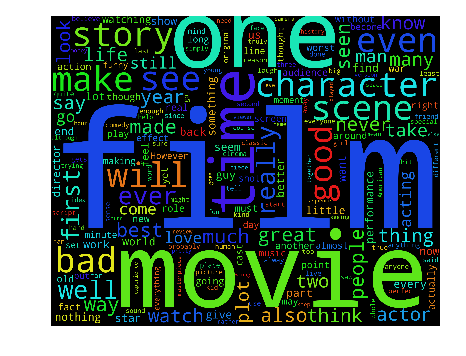

In [589]:
# Time for a word cloud!

genwordcloud = WordCloud(stopwords=STOPWORDS,
                     background_color='black',
                     width=3000,
                     height=2400).generate(' '.join(X))

plt.imshow(genwordcloud)
plt.axis('off')
plt.savefig('gen_review_wc.png',dpi=300)
plt.show()

In [129]:
# Create train/test split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [138]:
# Create vectorized matrices for modeling using tfidf

mf = TfidfVectorizer(stop_words='english')
mf.fit(X_train)

X_train_features = mf.transform(X_train)
X_test_features = mf.transform(X_test)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [891]:
X_train_features.shape

(1578, 23266)

In [331]:
# Vocabulary check

mf.vocabulary_

{u'raining': 16539,
 u'hordes': 10021,
 u'moskowitz': 13553,
 u'foul': 8323,
 u'woods': 23002,
 u'spiders': 19442,
 u'hanging': 9470,
 u'woody': 23004,
 u'comically': 4132,
 u'aggression': 743,
 u'wiseguys': 22924,
 u'canes': 3147,
 u'advantage': 652,
 u'originality': 14532,
 u'hallucinate': 9414,
 u'hermann': 9772,
 u'immature': 10371,
 u'sinking': 18835,
 u'courtmartial': 4784,
 u'bile': 2250,
 u'tantalizing': 20535,
 u'rawhide': 16666,
 u'oceano': 14306,
 u'stabbed': 19589,
 u'screaming': 18138,
 u'disturb': 6143,
 u'recollections': 16794,
 u'uttering': 22115,
 u'grueling': 9251,
 u'sommerset': 19244,
 u'wooden': 23000,
 u'synergy': 20433,
 u'commenter': 4157,
 u'voyeur': 22461,
 u'wednesday': 22695,
 u'happenings': 9489,
 u'persisted': 15184,
 u'crotch': 4987,
 u'stereotypical': 19753,
 u'commented': 4156,
 u'spinotti': 19461,
 u'sooty': 19270,
 u'undead': 21697,
 u'preface': 15847,
 u'scrapes': 18126,
 u'soots': 19269,
 u'miniatures': 13261,
 u'gorman': 9014,
 u'sustaining': 20308

In [812]:
# Initialize variables for modeling 2016 movie data

X2016 = c2016rbs.review
y2016 = c2016rbs.rating

X2016_features = mf.transform(X2016)

## NOTE: The regressions below are sample regressions that are later incorporated into a master scoring function. 

In [338]:
# Logistic regression

clf = LogisticRegression()
clf.fit(X_train_features,y_train)
y_pred = clf.predict(X_test_features)

print "Stats for reviews - All Time"
print confusion_matrix(y_test,y_pred)
print "Accuracy:",accuracy_score(y_test,y_pred)
print "5x AVG CV:",cross_val_score(clf,X_train_features,y_train,cv=5).mean()

print "----------------------------"

y2016_pred = clf.predict(X2016_features)
cv2016_scores = cross_val_score(clf,X2016_features,y2016,cv=5)

print "Stats for reviews - 2016"
print confusion_matrix(y2016,y2016_pred)
print "Accuracy:",accuracy_score(y2016,y2016_pred)
print "5x CV:",cv2016_scores.mean()

Stats for reviews - All Time
[[184  33]
 [ 38 140]]
Accuracy: 0.820253164557
5x AVG CV: 0.807357072819
----------------------------
Stats for reviews - 2016
[[337  25]
 [259 172]]
Accuracy: 0.641866330391
5x CV: 0.85231918239


In [402]:
# Processing text data into vectorized frame for feature processing and
# display top words across all reviews for 2016

gen_rev2016 = CountVectorizer(stop_words='english')
gen_rev2016.fit(X2016)

gen_rev2016.get_feature_names()
X2016_train = pd.DataFrame(gen_rev2016.transform(X2016).todense(),
                      columns=gen_rev2016.get_feature_names())

x2016_common = X2016_train.sum(axis=0)
pd.DataFrame(x2016_common.sort_values(ascending=False).head(25),columns=['wordcount'])

,wordcount
movie,2165
film,1589
like,846
just,817
good,574
story,563
really,539
time,460
characters,398
don,382


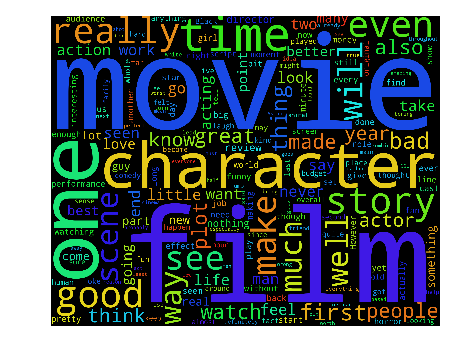

In [590]:
# More wordclouds

year2016wordcloud = WordCloud(stopwords=STOPWORDS,
                     background_color='black',
                     width=3000,
                     height=2400).generate(' '.join(X2016))

plt.imshow(year2016wordcloud)
plt.axis('off')
plt.savefig('year_2016_review_wc.png',dpi=300)
plt.show()

In [411]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(CountVectorizer(stop_words='english'),
                      LogisticRegression(),
                      )

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print "Accuracy (All-Time):",accuracy_score(y_test,y_pred)
print "Number of features:", len(model.steps[0][1].get_feature_names())
print "---------------------------------"
y2016_pred = model.predict(X2016)
print "Accuracy (2016):",accuracy_score(y2016,y2016_pred)
print "Number of features:", len(model.steps[0][1].get_feature_names())

Accuracy (All-Time): 0.8
Number of features: 23302
---------------------------------
Accuracy (2016): 0.696090794451
Number of features: 23302


In [609]:
# Practice in Bagging

DTree_clf = DecisionTreeClassifier()
Bagg_clf = BaggingClassifier(base_estimator=DTree_clf, n_estimators=20)

In [412]:
Bagg_clf.fit(X_train_features,y_train)

ybg_pred = Bagg_clf.predict(X_test_features)
print confusion_matrix(y_test,ybg_pred)
print "Accuracy:",accuracy_score(y_test,ybg_pred)
print "5x CV:",cross_val_score(Bagg_clf, X_train_features, y_train, cv=5).mean()
print "5x CV (2016):",cross_val_score(Bagg_clf, X2016_features, y2016, cv=5).mean()

[[163  54]
 [ 49 129]]
Accuracy: 0.739240506329
5x CV: 0.750318493461
5x CV (2016): 0.810721379667


In [351]:
# Use of the PorterStemmer did not result in any increase, thus was omitted 
# to reduce processing times. 

# porter = PorterStemmer()

# def tokenizer(text):
#     return text.split()


# def tokenizer_porter(text):
#     return [porter.stem(word) for word in text.split()]

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [STOPWORDS, None],
#                'vect__tokenizer': [None, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]}
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))
                     ])

cvmv = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

cvmv.fit(X_train,y_train)
y_predictions = cvmv.predict(X_test)
report = classification_report(y_test,y_predictions)

In [360]:
print "Best Score:",cvmv.best_score_
print "\nAll Time-----------------------"
print report

y2016_predictions = cvmv.predict(X2016)
report2 = classification_report(y2016, y2016_predictions)
print "(2016)-----------------------"
print report2

Best Score: 0.826362484157

All Time-----------------------
             precision    recall  f1-score   support

          0       0.82      0.84      0.83       217
          1       0.80      0.78      0.79       178

avg / total       0.81      0.81      0.81       395

(2016)-----------------------
             precision    recall  f1-score   support

        0.0       0.62      0.93      0.74       362
        1.0       0.89      0.52      0.66       431

avg / total       0.77      0.71      0.70       793



In [666]:
cvmv.best_params_

{'clf__C': 10.0,
 'clf__penalty': 'l2',
 'vect__ngram_range': (1, 1),
 'vect__stop_words': {'',
  'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  "can't",
  'cannot',
  'com',
  'could',
  "couldn't",
  'did',
  "didn't",
  'do',
  'does',
  "doesn't",
  'doing',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'get',
  'had',
  "hadn't",
  'has',
  "hasn't",
  'have',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  "he's",
  'her',
  'here',
  "here's",
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  "how's",
  'http',
  'i',
  "i'd",
  "i'll",
  "i'm",
  "i've",
  'if',
  'in',
  'into',
  'is',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  "let's",
  'like',
  'me',
  'more',
  'most',
  "mustn't",
 

In [674]:
pd.DataFrame(cvmv.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.719899,"[0.7, 0.739847715736]"
1,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.718631,"[0.712658227848, 0.72461928934]"
2,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.729404,"[0.721518987342, 0.73730964467]"
3,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.723067,"[0.721518987342, 0.72461928934]"
4,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.807351,"[0.781012658228, 0.833756345178]"
5,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.806084,"[0.783544303797, 0.828680203046]"
6,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.795944,"[0.76835443038, 0.823604060914]"
7,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.785171,"[0.762025316456, 0.808375634518]"
8,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.762357,"[0.739240506329, 0.785532994924]"
9,"{u'vect__ngram_range': (1, 1), u'vect__tokeniz...",0.778834,"[0.787341772152, 0.770304568528]"


In [414]:
# Practice in Random Tree Classifier

rfclf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)


rfclf.fit(X_train_features,y_train)

yrf_predict = rfclf.predict(X_test_features)

rfscores = cross_val_score(rfclf, X_train_features, y_train)

print "All Time Movies----------------------"
print confusion_matrix(y_test,yrf_predict)
print "Random Tree Accuracy:",accuracy_score(y_test,yrf_predict)
print "Random Tree Mean Score:",rfscores.mean()                             
print "Random Tree Scores:",rfscores
print "-------------------------------------"

y2016rf_predict = rfclf.predict(X2016_features)
rf2016scores = cross_val_score(rfclf, X2016_features, y2016, cv=5)

print "All 2016 Movies----------------------"
print confusion_matrix(y2016,y2016rf_predict)
print "Random Tree Accuracy:",accuracy_score(y2016,y2016rf_predict)
print "Random Tree Mean Score:",rf2016scores.mean()                             
print "Random Tree Scores:",rf2016scores
print "-------------------------------------"

All Time Movies----------------------
[[183  34]
 [ 71 107]]
Random Tree Accuracy: 0.73417721519
Random Tree Mean Score: 0.717363751584
Random Tree Scores: [ 0.73764259  0.70532319  0.70912548]
-------------------------------------
All 2016 Movies----------------------
[[311  51]
 [251 180]]
Random Tree Accuracy: 0.619167717528
Random Tree Mean Score: 0.791900923493
Random Tree Scores: [ 0.8375      0.72327044  0.82278481  0.79746835  0.77848101]
-------------------------------------


In [416]:
# Practice in KNN

kclf = KNeighborsClassifier(5)

kclf.fit(X_train_features,y_train)

print "5x CV:",cross_val_score(kclf, X_train_features, y_train, cv=5).mean()

yk_pred = kclf.predict(X_test_features)

print confusion_matrix(y_test,yk_pred)
print classification_report(y_test, yk_pred)

0.796593509957
[[173  44]
 [ 32 146]]
             precision    recall  f1-score   support

          0       0.84      0.80      0.82       217
          1       0.77      0.82      0.79       178

avg / total       0.81      0.81      0.81       395



In [418]:
# Practice in SVC

svc_params = {
    'C':np.logspace(1e-4, 1e1, 3),
    'kernel':['linear']
}

svc_gs = GridSearchCV(SVC(), svc_params, cv=2)
svc_gs.fit(X_train_features, y_train)

ysvc_pred = svc_gs.predict(X_test_features)

print confusion_matrix(y_test,ysvc_pred)
print "Best Estimator:",svc_gs.best_estimator_
print "Best Paraters:", svc_gs.best_params_
print "Best Score:", svc_gs.best_score_

[[178  39]
 [ 31 147]]
Best Estimator: SVC(C=1.0002302850208247, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Paraters: {'kernel': 'linear', 'C': 1.0002302850208247}
Best Score: 0.826362484157


In [419]:
# Practice in KNN and GridSearching

knn_params = {
    'n_neighbors':range(5,20),
    'weights':['distance','uniform']
}

knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_gs.fit(X_train_features, y_train)

knny_pred = knn_gs.predict(X_test_features)

knny_cmx = classification_report(y_test,knny_pred)

knn_best = knn_gs.best_estimator_

print "Best Estimator:",knn_best
print "Best Paramters:",knn_gs.best_params_
print "Best Score:",knn_gs.best_score_

Best Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='distance')
Best Paramters: {'n_neighbors': 19, 'weights': 'distance'}
Best Score: 0.82319391635


In [383]:
print classification_report(y_test,knny_pred)

             precision    recall  f1-score   support

          0       0.87      0.80      0.83       217
          1       0.78      0.86      0.82       178

avg / total       0.83      0.83      0.83       395



In [886]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    plt.figure(figsize=[6,5])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score, subtitle):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC -'+subtitle)

In [878]:
# Main Model Scoring Function

def get_regscores(Xtr,ytr,Xte,yte,Xtr_Orig,Xte_Orig,ytr_alt=''):

    scores = []
    
    # Logistic Regression
    clf = LogisticRegression()
    clf.fit(Xtr,ytr)
    y_pred = clf.predict(Xte)
    
    cv_scores_mean = cross_val_score(clf,Xtr,ytr,cv=5).mean()
    cv_accuracy = accuracy_score(yte,y_pred)
    cv_prec = classification_report(yte, y_pred).split('total')[1].split('   ')[2].strip()
    cv_rec = classification_report(yte, y_pred).split('total')[1].split('   ')[4]
    
    cv_Yall_score = clf.predict_proba(Xte)[:,1]
    cv_fpr, cv_tpr, _ = roc_curve(yte, cv_Yall_score)
    cv_roc_auc = auc(cv_fpr, cv_tpr)
    
    cv_pr, cv_rc, _ = precision_recall_curve(yte, cv_Yall_score)
    cv_roc_pr = auc(cv_rc,cv_pr)
    
    plot_roc(yte,cv_Yall_score,"Logistic")
    
    scores.append(['Logistic',round(cv_scores_mean,6),
                   round(cv_accuracy,6),
                   round(float(cv_prec),6),
                   round(float(cv_rec),6),
                   round(cv_fpr.mean(),6),
                   round(cv_roc_auc,6),round(cv_roc_pr,6)])    
    
    # Grid Search Logistic
    gl_params = {
        'penalty':['l1','l2'],
        'C':np.linspace(1e-4,1e2, 5)
    }

    gs_cv = GridSearchCV(LogisticRegression(), gl_params, cv=5)
    gs_cv.fit(Xtr, ytr)
    ygscv_pred = gs_cv.predict(Xte)
    
    gscv_scores_mean = cross_val_score(gs_cv,Xtr,ytr,cv=5).mean()
    gscv_accuracy = accuracy_score(yte,ygscv_pred)
    gscv_prec = classification_report(yte, ygscv_pred).split('total')[1].split('   ')[2].strip()
    gscv_rec = classification_report(yte, ygscv_pred).split('total')[1].split('   ')[4]
    
    gscv_Yall_score = gs_cv.predict_proba(Xte)[:,1]
    gscv_fpr, gscv_tpr, _ = roc_curve(yte, gscv_Yall_score)
    gscv_roc_auc = auc(gscv_fpr, gscv_tpr)
    
    gscv_pr, gscv_rc, _ = precision_recall_curve(yte, gscv_Yall_score)
    gscv_roc_pr = auc(gscv_rc,gscv_pr)

    plot_roc(yte,gscv_Yall_score, "GridSearch - Logistic")    
    
    scores.append(['GridSearch Logistic',round(gscv_scores_mean,6),
                   round(gscv_accuracy,6),
                   round(float(gscv_prec),6),
                   round(float(gscv_rec),6),
                   round(gscv_fpr.mean(),6),
                   round(gscv_roc_auc,6),round(gscv_roc_pr,6)])
    
    
    # Grid Search Logistic/TFIDF
    
    tfidf = TfidfVectorizer(strip_accents=None,
                            lowercase=False,
                            preprocessor=None)

    param_grid = [{'vect__ngram_range': [(1, 1)],
                   'vect__stop_words': [STOPWORDS, None],
                   'clf__penalty': ['l1', 'l2'],
                   'clf__C': [1.0, 10.0]}
                  ]

    lr_tfidf = Pipeline([('vect', tfidf),
                         ('clf', LogisticRegression(random_state=0))
                         ])

    cvmv = GridSearchCV(lr_tfidf, param_grid,
                               scoring='accuracy',
                               cv=2,
                               n_jobs=-1)

    cvmv.fit(Xtr_Orig,ytr)
    ycvmv_pred = cvmv.predict(Xte_Orig)

    cvmv_scores_mean = cross_val_score(cvmv,Xtr_Orig,ytr,cv=5).mean()
    cvmv_accuracy = accuracy_score(yte,ycvmv_pred)
    cvmv_prec = classification_report(yte, ycvmv_pred).split('total')[1].split('   ')[2].strip()
    cvmv_rec = classification_report(yte, ycvmv_pred).split('total')[1].split('   ')[4]
    
    cvmv_Yall_score = cvmv.predict_proba(Xte_Orig)[:,1]
    cvmv_fpr, cvmv_tpr, _ = roc_curve(yte, cvmv_Yall_score)
    cvmv_roc_auc = auc(cvmv_fpr, cvmv_tpr)
    
    cvmv_pr, cvmv_rc, _ = precision_recall_curve(yte, cvmv_Yall_score)
    cvmv_roc_pr = auc(cvmv_rc,cvmv_pr)

    plot_roc(yte,cvmv_Yall_score, "GridSearch - Log/TFIDF")     
    
    scores.append(['GridSearch Log/TFIDF',round(cvmv_scores_mean,6),
                   round(cvmv_accuracy,6),
                   round(float(cvmv_prec),6),
                   round(float(cvmv_rec),6),
                   round(cvmv_fpr.mean(),6),
                   round(cvmv_roc_auc,6),round(cvmv_roc_pr,6)])

    
    # Grid Search KNN
    knn_params = {
        'n_neighbors':range(5,20),
        'weights':['distance','uniform']
    }

    knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
    knn_gs.fit(Xtr, ytr)
    yknn_pred = knn_gs.predict(Xte)

    knn_scores_mean = cross_val_score(knn_gs,Xtr,ytr,cv=5).mean()
    knn_accuracy = accuracy_score(yte,yknn_pred)
    knn_prec = classification_report(yte, yknn_pred).split('total')[1].split('   ')[2].strip()
    knn_rec = classification_report(yte, yknn_pred).split('total')[1].split('   ')[4]
    
    knn_Yall_score = knn_gs.predict_proba(Xte)[:,1]
    knn_fpr, knn_tpr, _ = roc_curve(yte, knn_Yall_score)
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    
    knn_pr, knn_rc, _ = precision_recall_curve(yte, knn_Yall_score)
    knn_roc_pr = auc(knn_rc,knn_pr)
    
    plot_roc(yte,knn_Yall_score,"GridSearch - KNN") 
    
    scores.append(['GridSearch KNN',round(knn_scores_mean,6),
                   round(knn_accuracy,6),
                   round(float(knn_prec),6),
                   round(float(knn_rec),6),
                   round(knn_fpr.mean(),6),
                   round(knn_roc_auc,6),round(knn_roc_pr,6)])
    
    
    # Grid Search SVM  
    svc_params = {
        'C':np.logspace(1e-4, 1e1, 3),
        'kernel':['linear']
    }

    gs_svc = GridSearchCV(SVC(), svc_params, cv=2)
    gs_svc.fit(Xtr, ytr)    
    ygs_pred = gs_svc.predict(Xte)
    
    gsvm_scores_mean = cross_val_score(gs_svc,Xtr,ytr,cv=5).mean()
    gsvm_accuracy = accuracy_score(yte,ygs_pred)
    gsvm_prec = classification_report(yte, ygs_pred).split('total')[1].split('   ')[2].strip()
    gsvm_rec = classification_report(yte, ygs_pred).split('total')[1].split('   ')[4]
    
    gsvm_Yall_score = knn_gs.predict_proba(Xte)[:,1]
    gsvm_fpr, gsvm_tpr, _ = roc_curve(yte, gsvm_Yall_score)
    gsvm_roc_auc = auc(gsvm_fpr, gsvm_tpr)
    
    gsvm_pr, gsvm_rc, _ = precision_recall_curve(yte, gsvm_Yall_score)
    gsvm_roc_pr = auc(gsvm_rc,gsvm_pr)
    
    plot_roc(yte,gsvm_Yall_score,"GridSearch SVM") 
    
    scores.append(['GridSearch SVM',round(gsvm_scores_mean,6),
                   round(gsvm_accuracy,6),
                   round(float(gsvm_prec),6),
                   round(float(gsvm_rec),6),
                   round(gsvm_fpr.mean(),6),
                   round(gsvm_roc_auc,6),round(gsvm_roc_pr,6)])
    
    
    #Bagg/Decision Tree
    DTree_clf = DecisionTreeClassifier()
    Bagg_clf = BaggingClassifier(base_estimator=DTree_clf, n_estimators=20)
    Bagg_clf.fit(Xtr,ytr)
    ybg_pred = Bagg_clf.predict(Xte)
    
    bagg_scores_mean = cross_val_score(Bagg_clf, Xtr, ytr, cv=5).mean()
    bagg_accuracy = accuracy_score(yte,ybg_pred)
    bagg_prec = classification_report(yte, ybg_pred).split('total')[1].split('   ')[2].strip()
    bagg_rec = classification_report(yte, ybg_pred).split('total')[1].split('   ')[4]
    
    bagg_Yall_score = Bagg_clf.predict_proba(Xte)[:,1]
    bagg_fpr, bagg_tpr, _ = roc_curve(yte, bagg_Yall_score)
    bagg_roc_auc = auc(bagg_fpr, bagg_tpr)
    
    bagg_pr, bagg_rc, _ = precision_recall_curve(yte, bagg_Yall_score)
    bagg_roc_pr = auc(bagg_rc,bagg_pr)
    
    plot_roc(yte,bagg_Yall_score, "Bagg/DecisionTree") 
    
    scores.append(['Bagging/Decision Tree',round(bagg_scores_mean,6),
                   round(bagg_accuracy,6),
                   round(float(bagg_prec),6),
                   round(float(bagg_rec),6),
                   round(bagg_fpr.mean(),6),
                   round(bagg_roc_auc,6),round(bagg_roc_pr,6)])
    
    
    # Random Forest
    rfclf = RandomForestClassifier(n_estimators=20, max_depth=None, min_samples_split=2, random_state=0)
    rfclf.fit(Xtr,ytr)

    yrf_pred = rfclf.predict(Xte)

    rf_scores_mean = cross_val_score(rfclf, Xtr, ytr, cv=5).mean()
    rf_accuracy = accuracy_score(yte,yrf_pred)
    rf_prec = classification_report(yte, yrf_pred).split('total')[1].split('   ')[2].strip()
    rf_rec = classification_report(yte, yrf_pred).split('total')[1].split('   ')[4]
    
    rf_Yall_score = rfclf.predict_proba(Xte)[:,1]
    rf_fpr, rf_tpr, _ = roc_curve(yte, rf_Yall_score)
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    
    rf_pr, rf_rc, _ = precision_recall_curve(yte, rf_Yall_score)
    rf_roc_pr = auc(rf_rc,rf_pr)
    
    plot_roc(yte,rf_Yall_score, "Random Forest") 
    
    scores.append(['Random Forest',round(rf_scores_mean,6),
                   round(rf_accuracy,6),
                   round(float(rf_prec),6),
                   round(float(rf_rec),6),
                   round(rf_fpr.mean(),6),
                   round(rf_roc_auc,6),round(rf_roc_pr,6)])
    
    
    
    return scores
 

# Model Summaries

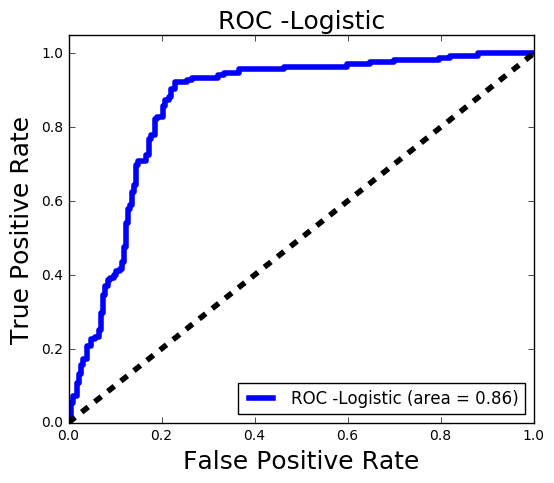

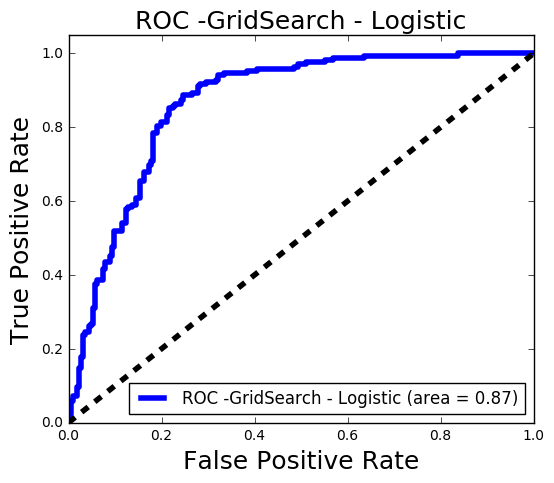

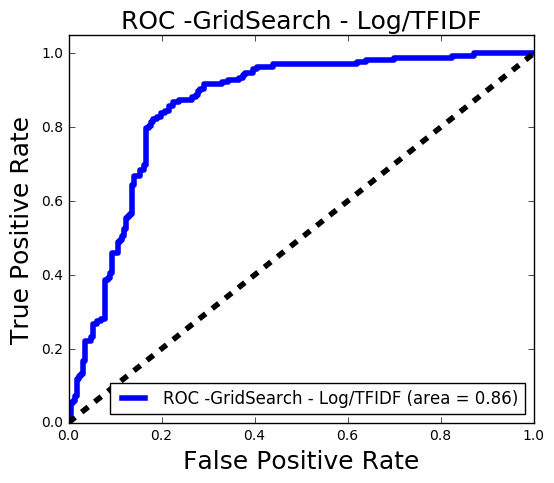

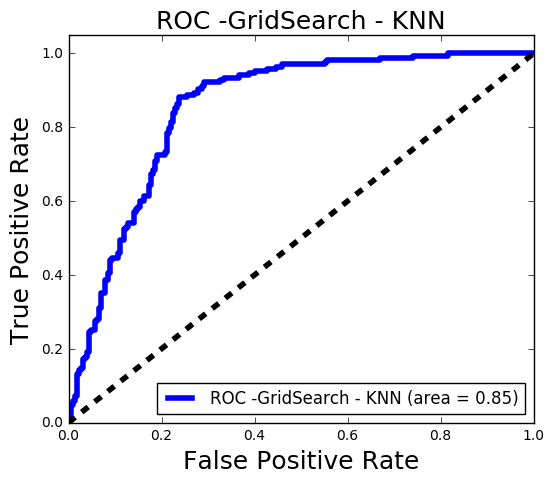

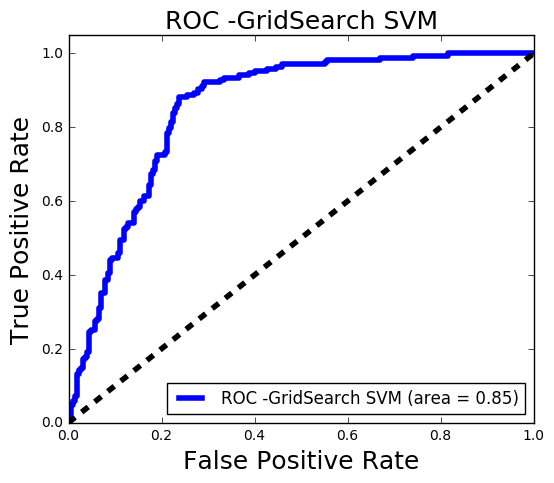

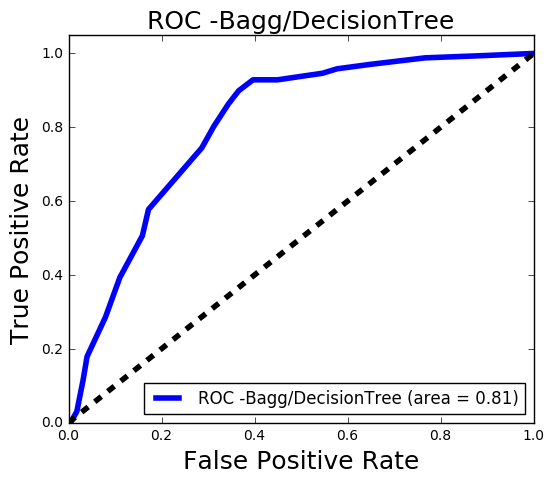

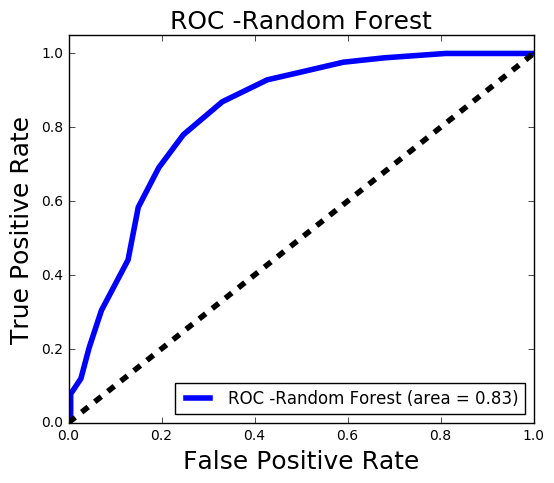

In [887]:
alltime_scores = get_regscores(X_train_features, y_train, X_test_features, y_test, X_train, X_test)

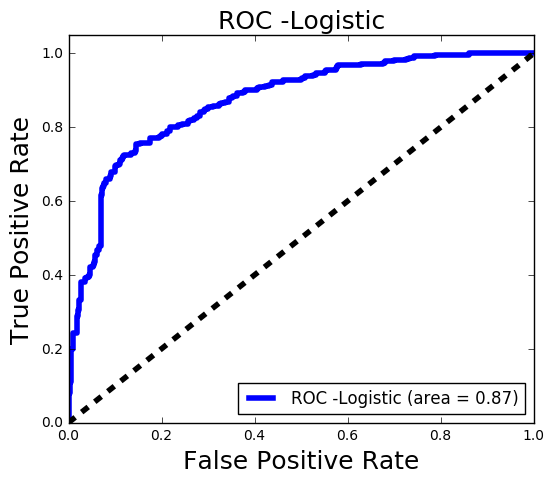

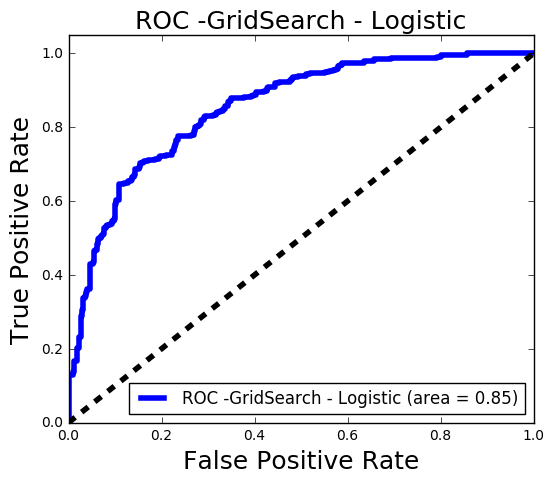

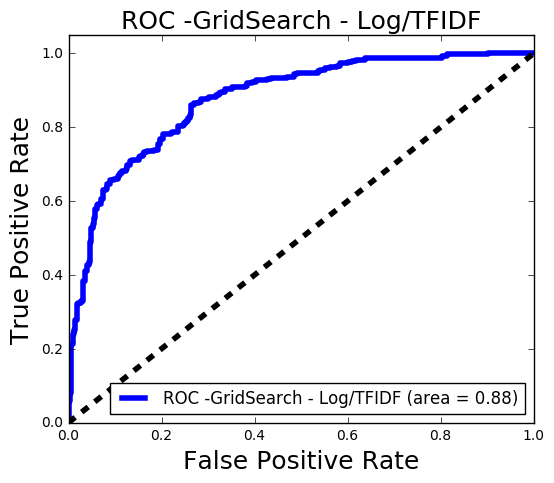

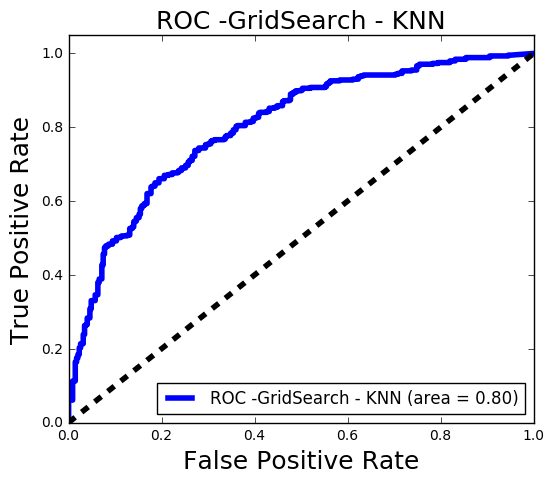

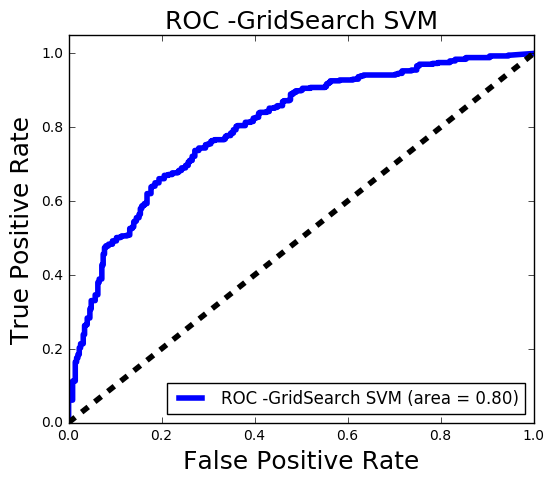

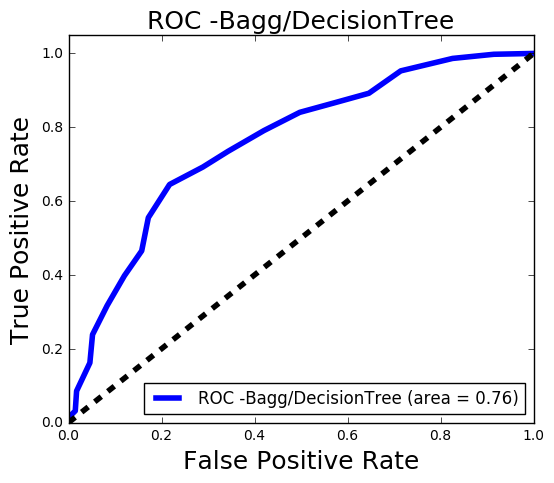

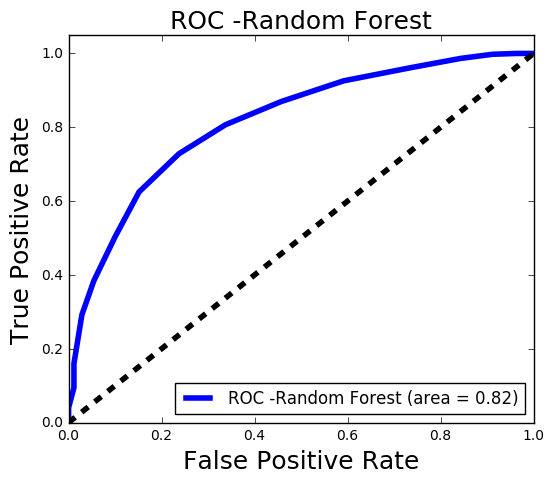

In [888]:
year2016_scores = get_regscores(X_train_features, y_train, X2016_features, y2016, X_train, X2016)

In [882]:
pd.DataFrame(alltime_scores,
             columns=['Model','Mean CV (5x)','Accuracy','Precision','Recall','False Pos Rate','AUC ROC','AUC PR'])

,Model,Mean CV (5x),Accuracy,Precision,Recall,False Pos Rate,AUC ROC,AUC PR
0,Logistic,0.821312,0.812658,0.82,0.81,0.222599,0.860053,0.753939
1,GridSearch Logistic,0.823199,0.800000,0.80,0.80,0.220055,0.865875,0.774987
2,GridSearch Log/TFIDF,0.825095,0.815190,0.82,0.82,0.224981,0.859817,0.761469
3,GridSearch KNN,0.821929,0.800000,0.82,0.80,0.221401,0.853210,0.754256
4,GridSearch SVM,0.837782,0.815190,0.83,0.82,0.221401,0.853210,0.754256
5,Bagging/Decision Tree,0.756032,0.751899,0.76,0.75,0.344413,0.820380,0.687116
6,Random Forest,0.763637,0.756962,0.76,0.76,0.403524,0.829911,0.732226


In [885]:
pd.DataFrame(year2016_scores,
             columns=['Model','Mean CV (5x)','Accuracy','Precision','Recall','False Pos Rate','AUC ROC','AUC PR'])

,Model,Mean CV (5x),Accuracy,Precision,Recall,False Pos Rate,AUC ROC,AUC PR
0,Logistic,0.821312,0.703145,0.77,0.70,0.324131,0.870876,0.892030
1,GridSearch Logistic,0.823199,0.711950,0.76,0.71,0.323648,0.853066,0.873059
2,GridSearch Log/TFIDF,0.825095,0.744654,0.80,0.74,0.334540,0.876758,0.894862
3,GridSearch KNN,0.821929,0.711950,0.74,0.71,0.353654,0.802022,0.830026
4,GridSearch SVM,0.837782,0.753459,0.78,0.75,0.353654,0.802022,0.830026
5,Bagging/Decision Tree,0.756663,0.652830,0.69,0.65,0.344857,0.754575,0.789647
6,Random Forest,0.763637,0.677987,0.74,0.68,0.390827,0.815551,0.845890


## Last Minute Takeaways
### (Note: These were added during presentations)

- Loop through range of estimators for Bagg/DT
- Consider reducing dictionary size?
- Further breakdown of classification
- Is the english vernacular different between reviews written for Top 250 all time vs. 2016?
- Do film genres invite reviewers that use different terms that are not applicable to other films?
- Given Keith's use of RF as base estimator for Bagg/DT, would that help?
- Next time, store collected data for later use in case original online source becomes unavailable (pickl)